# Titanic

## Importações

In [123]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import KFold, cross_validate, train_test_split, GridSearchCV


## Conhecendo e explorando a base de dados

### Lendo e limpando a base de dados

Neste notebook iremos explorar a base de dados do naufrágio do Titanic. Nesta base de dados temos dados dos passageiros a bordo, e a informação de que o passageiro morreu no acidente ou não.

Abaixo, será especificado o que representa cada uma das colunas do dataet:

- PassengerId: número de identificação do passageiro;
- Survived: indica se o passageiro sobreviveu ao desastre.
- Pclass: classe na qual o passageiro viajou. 
- Name: mome do passageiro;
- Sex: sexo do passageiro;
- Age: idade do passageiro;
- SibSp: quantidade de irmãos e cônjuges a bordo;
- Parch: quantidade de pais e filhos a bordo;
- Ticket: número da passagem;
- Fare: preço da passagem;
- Cabin: número da cabine do passageiro;
- Embarked: indica o porto no qual o passageiro embarcou.

In [124]:
df = pd.read_csv('titanic.csv')

print(df.shape)

df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Neste dataset, existem três colunas de dados irrelevantes para o modelo de Machine Learning que será construidos, são elas: 'Name', 'Ticket' e 'Cabin', que contém o nome do passageiro, o número da passagem e da cabine. Logo, vamos retirar estas colunas do nosso dataframe:

In [125]:
df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


Nota-se que os atributos 'Sex' e 'Embarked' são variáveis não numéricas e, dado que modelos do Sklearn só aceitam variáveis númericas teremos que categorizar as variáveis do tipo string para valor númerico.

In [127]:
df.isnull().sum().sort_values(ascending=False)

Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Sex              0
SibSp            0
Parch            0
Fare             0
dtype: int64

Note também que os atributos 'Age' e 'Embarked' possuem valores faltantes. Mais uma tarefa de pré-processamento para ser feito em nosso pipeline.

Esforços foram feitos para imputar os valores faltantes do atributo Embarked (coluna de valores não numéricos) diretamente no pipeline do modelo, mas mesmo usando o strategy='most_frequent' que normalmente é usado para atributos não numéricos, não obtive sucesso. Também tentei primeiro codificar os valores para númericos e em seguida aplicar o imputer mas também não funcionou. Então, os valores faltantes do atributo 'Embarked' serão imputados fora do pipeline do modelo utilizando o pandas, onde que o valor mais frequente será imputado no valor faltante. Já o atributo 'Age', por ser um valor numérico, será imputado no pipeline.

In [128]:
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].value_counts().index[0])

In [129]:
df.isnull().sum().sort_values(ascending=False)

Age            177
PassengerId      0
Survived         0
Pclass           0
Sex              0
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

Pronto, imputamos os valores faltantes do 'Embarked'.

### Visualização gráfica da base de dados

Antes de partir para a aplicação dos algoritmos de classificação em nossa base, vamos primeiro visualizá-la graficamente a fim de ver se conseguimos extrair alguns insights prévios.

#### Proporção de sobreviventes

In [130]:
df["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

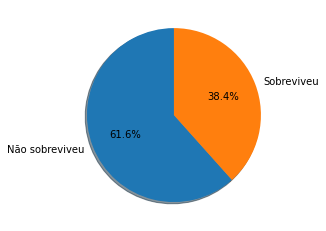

In [131]:
survival_count = df["Survived"].value_counts()
labels = ['Não sobreviveu', 'Sobreviveu']

plt.pie(survival_count, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()

61% dos passageiros morreram no acidente. Esta base é uma amostragem dos passageiros do návio, não contendo todas as pessoas que estavam de fato a bordo do titanic, então a proporção real pode ser ligeiramente diferente.

#### Gênero

Porcentagem de mulheres que sobreviveram: 74.20382165605095
Porcentagem de homens que sobreviveram: 18.890814558058924


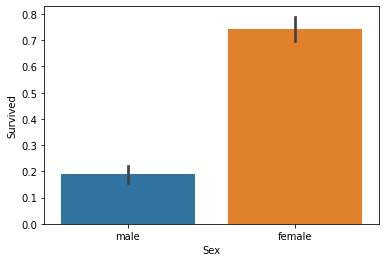

In [132]:
print("Porcentagem de mulheres que sobreviveram:", df["Survived"][df["Sex"] == 'female'].value_counts(normalize = True)[1]*100)
print("Porcentagem de homens que sobreviveram:", df["Survived"][df["Sex"] == 'male'].value_counts(normalize = True)[1]*100)

fig = plt.Figure()
sns.barplot(x="Sex", y="Survived", data=df)
plt.show()

Aqui vemos que a chance de um passageiro ter sobrevivido está altamente relacionada ao sexo do passageiro. A história nos diz que as primeiras pessoas a serem evacuadas foram mulheres e crianças, por isso a porcentagem de mulheres que sobreviveram foi maior.

#### Classe

Porcentagem de passageiros da classe 1 que sobreviveram: 62.96296296296296
Porcentagem de passageiros da classe 2 que sobreviveram: 47.28260869565217
Porcentagem de passageiros da classe 3 que sobreviveram: 24.236252545824847


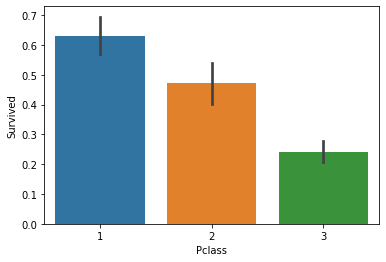

In [133]:
print("Porcentagem de passageiros da classe 1 que sobreviveram:", df["Survived"][df["Pclass"] == 1].value_counts(normalize = True)[1]*100)
print("Porcentagem de passageiros da classe 2 que sobreviveram:", df["Survived"][df["Pclass"] == 2].value_counts(normalize = True)[1]*100)
print("Porcentagem de passageiros da classe 3 que sobreviveram:", df["Survived"][df["Pclass"] == 3].value_counts(normalize = True)[1]*100)

fig = plt.Figure()
sns.barplot(x="Pclass", y="Survived", data=df)
plt.show()

Notamos que os passageiros da primeira classe (classe mais nobre) teve uma maior taxa de sobrevivência que os passageiros da segunda e terceira classe. Provavelmente nessa classe havia mais recursos de emergência, ou estava localizada em uma seção do navio que facilitasse o resgate. 

### Companheiros a bordo

Na base de dados existem as colunas 'SibSp' e 'Parch' que nos informam, respectivamente, a quantidade de irmãos/cônjuges a bordo e quantidade de pais/filhos a bordo. Vamos fazer uma feature engineering e juntar essas duas colunas em uma única informação: a quantidade de familiares a bordo, e em seguida ver a sua relação com a taxa de sobrevivência. 

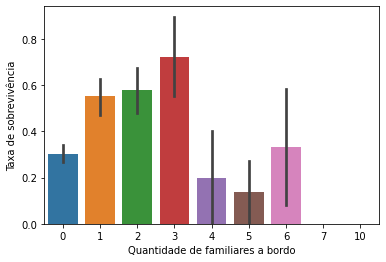

In [134]:
family_count = df['SibSp'] + df['Parch']

fig = plt.Figure()
sns.barplot(x=family_count, y=df['Survived'])
plt.xlabel("Quantidade de familiares a bordo")
plt.ylabel("Taxa de sobrevivência")
plt.show()

O pensamento natural é que pessoas com mais familiares a bordo tem menores chances de sobreviver. Porém, contrariando as expectativas, pessoas com nenhum familiar a bordo tiveram uma taxa de sobrevivência menor que pessoas com 1, 2 e 3 familiares a bordo.

Este gráfico mostra apenas a taxa de sobrevivência, mas quantas amostras temos de passageiros com nenhum familiar, 1 familiar, 2 familiares e assim por diante? Vamos plotar a diante um gráfico que nos mostra a frequência de cada ocorrência de quantidade de familiares a bordo, a fim de validar a observação de que pessoas com nenhum familiar tem uma taxa menor de sobrevivência que pessoas com 1, 2 e 3 familiares a bordo. 

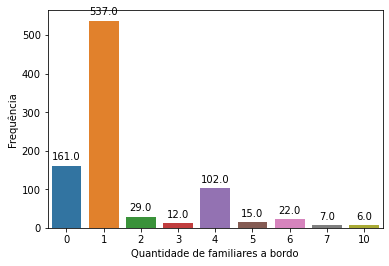

In [135]:
fig = plt.Figure()
splot = sns.barplot(x=family_count.unique(), y=family_count.value_counts().unique())
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Quantidade de familiares a bordo")
plt.ylabel("Frequência")
plt.show()

Notamos que a ocorrência de passageiros com 2 ou 3 familiares é muito pequena no dataset, podendo ser este o motivo da taxa de sobrevivência maior que passageiros com nenhum familiar. Por outro lado, a maioria dos passageiros do dataset possuia apenas 1 familiar a bordo, e mesmo com a amostra grande, temos que estes passageiros tiveram maiores chances de sobreviver que viajantes solos.

## Modelo de Classificação

O que queremos analisar aqui é: Com base nas informações do passageiro, podemos predizer se ele morreu no acidente? Ou seja, uma classificação binária que vai dizer se o passageiro sobreviveu (1) ou morreu (0).

Vamos experimentar aplicar dois modelos de classificação em nossos dados, o decision tree classifier e o random forest classifier:

### Aplicando o DecisionTreeClassifier

#### Pipeline

Vamos então construir nosso pipeline:

In [136]:
model = Pipeline(steps=[
    ('enconding', OneHotEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('clf', DecisionTreeClassifier(random_state=0))
])

#### Treino e teste

Posteriormente, iremos tunar nossos parâmetros procurando a combinação que torne nosso modelo mais robusto, mas a princípio, de maneira despretenciosa vamos treinar nosso modelo com 20% dos dados e testar com os 80% restantes e ver como ele se sai: 

In [137]:
# dividindo em conjunto de treino e test
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Survived'], axis=1), 
                                                    df['Survived'], 
                                                    test_size=0.2, 
                                                    random_state=42)


# treinando o modelo
model.fit(X_train, y_train)
train_score = model.score(X_train, y_train)

# avaliando o modelo
test_score = model.score(X_test, y_test)

print("Train score: {}".format(train_score))
print("Test score: {}".format(test_score))

predicted = model.predict(X_test)

Train score: 1.0
Test score: 0.7374301675977654


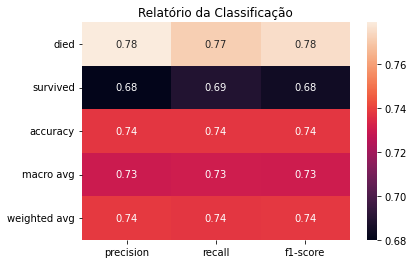

In [138]:
labels = np.arange(2)
clf_report = classification_report(y_test, predicted, labels=labels, target_names=('died','survived'), output_dict=True)
ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
ax.set_title('Relatório da Classificação')
plt.show()

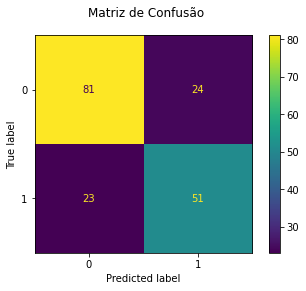

In [139]:
disp = plot_confusion_matrix(model, X_test, y_test)
disp.figure_.suptitle("Matriz de Confusão")
plt.show()

Observamos que o modelo teve 78% de precisão no palpites de morte e 68% nos palpites de sobrevivência. Vamos tentar melhorá-lo?

#### Otimização de parâmetros

Com o GridSearchCV podemos automatizar o processo de ajuste dos parâmetros de um algoritmo. Ele fará de maneira sistemática diversas combinações dos parâmetros e depois de avaliá-los os armazenará num único objeto.

In [140]:
# Tunando hiperparâmetros com 5-fold cross-validation e pipelines
parameters = {
                'clf__max_depth': [None, 3, 4, 5, 10],
                'clf__criterion': ['gini', 'entropy'],
                'clf__splitter': ['best', 'random'],
                'clf__max_features': [None, 'auto', 'sqrt', 'log2']

            }

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(model, param_grid=parameters, cv=kfold, n_jobs=-1, return_train_score=True)
grid.fit(X=df.drop(['Survived'], axis=1), y=df['Survived'])

cv_results = pd.DataFrame(grid.cv_results_)[['params','mean_test_score']].sort_values('mean_test_score', ascending=False, ignore_index=True)

Na tabela abaixo, temos ordenado da melhor para a pior combinação de parâmetros.

In [141]:
cv_results

,params,mean_test_score
0,"{'clf__criterion': 'gini', 'clf__max_depth': 3...",0.815956
1,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.814833
2,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.814814
3,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.814814
4,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.814814
...,...,...
75,"{'clf__criterion': 'gini', 'clf__max_depth': N...",0.756431
76,"{'clf__criterion': 'gini', 'clf__max_depth': N...",0.756431
77,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.754221
78,"{'clf__criterion': 'gini', 'clf__max_depth': N...",0.751980


Abaixo é executado o modelo com a melhor combinação de parâmetros para o conjunto de testes:

In [142]:
predicted = grid.predict(X_test)

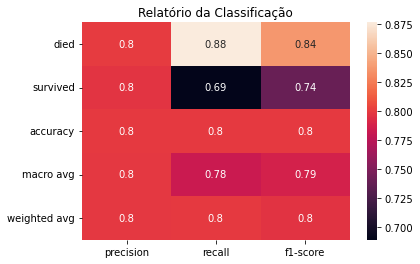

In [143]:
labels = np.arange(2)
clf_report = classification_report(y_test, predicted, labels=labels, target_names=('died','survived'), output_dict=True)
ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
ax.set_title('Relatório da Classificação')
plt.show()

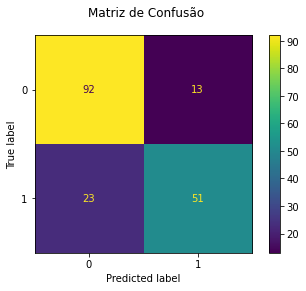

In [144]:
disp = plot_confusion_matrix(grid, X_test, y_test)
disp.figure_.suptitle("Matriz de Confusão")
plt.show()

Notamos uma bela melhoria comparado à nossa execução anterior, antes de ter calibrado os parâmetros.

Para fins ilustrativos, é possível plotar o esquema da árvore de decisão formada a partir do modelo. Mas como pode ser visto abaixo, a árvore ficou bem extensa, não sendo possível ler as informações da figura, a menos que seja feita um tratamento nela.

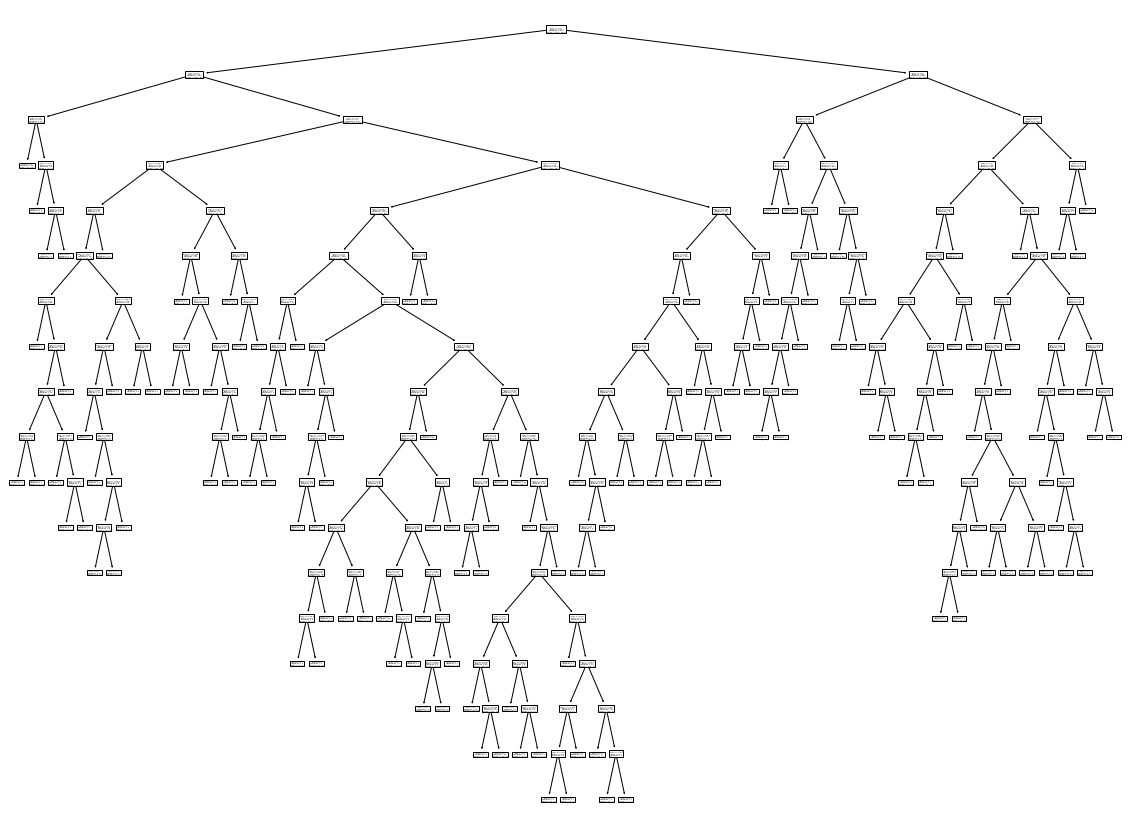

In [145]:
fig = plt.figure(figsize=(20,15))
plot_tree(model['clf'])
plt.show()

#### Validação

Este modelo é consistente? Com a validação cruzada k-fold podemos verificar a eficácia do algoritmo. Iremos divir nossos dados em k=5 grupos e, em seguida, executar o modelo usando um grupo diferente como o conjunto de teste em cada iteração.

In [146]:
# validando o modelo usando 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = cross_validate(grid, X=df.drop(['Survived'], axis=1), y=df['Survived'], cv=kfold)

print(results['test_score'])
print("Average accuracy: %f (%f)" %(results['test_score'].mean(), results['test_score'].std()))

[0.79888268 0.79775281 0.85393258 0.79213483 0.8258427 ]
Average accuracy: 0.813709 (0.023260)


Para as cinco iterações, a acurácia média foi de 81%, tendo um desvio padrão de 2%.

### Aplicando o RandomForestClassifier

Diferente de todo o passo a passo feito com o DecisionTreeClassifier, vamos direto definir o pipeline e já executar o GridSearch para encontrar a melhor combinação de parâmetros e por consequência o melhor score para vermos se conseguimos superar o DecisionTreeClassifier:

In [147]:
model = Pipeline(steps=[
    ('enconding', OneHotEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('clf', RandomForestClassifier(random_state=0))
])

In [148]:
parameters = {
              'clf__n_estimators': [10, 50, 100], 
              'clf__max_features': ['log2', 'sqrt','auto'], 
              'clf__criterion': ['entropy', 'gini'],
              'clf__max_depth': [None, 2, 3, 5, 10], 
              'clf__min_samples_split': [2, 3, 5],
              'clf__min_samples_leaf': [1,5,8]
             }

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(model, param_grid=parameters, cv=kfold, n_jobs=-1, return_train_score=True)
grid.fit(X=df.drop(['Survived'], axis=1), y=df['Survived'])

cv_results = pd.DataFrame(grid.cv_results_)[['params','mean_test_score']].sort_values('mean_test_score', ascending=False, ignore_index=True)

In [149]:
cv_results

,params,mean_test_score
0,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.833915
1,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.833915
2,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.833915
3,"{'clf__criterion': 'gini', 'clf__max_depth': N...",0.832785
4,"{'clf__criterion': 'gini', 'clf__max_depth': N...",0.832785
...,...,...
805,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.785638
806,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.785638
807,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.785638
808,"{'clf__criterion': 'entropy', 'clf__max_depth'...",0.785638


Houve uma melhora em relação ao que obtivemos na árvore de decisão.

In [150]:
predicted = grid.predict(X_test)

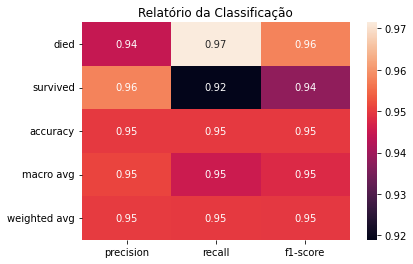

In [151]:
labels = np.arange(2)
clf_report = classification_report(y_test, predicted, labels=labels, target_names=('died','survived'), output_dict=True)
ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
ax.set_title('Relatório da Classificação')
plt.show()

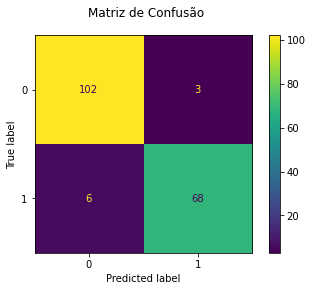

In [152]:
disp = plot_confusion_matrix(grid, X_test, y_test)
disp.figure_.suptitle("Matriz de Confusão")
plt.show()

Conseguimos uma precisão de 94% nas predições de morte e 96% nas predições de sobrevivência, com um f1-score próximo de 1 (o melhor valor) em ambos os casos. Nada mal hein!

Vamos validar nosso modelo com o cross validation 5-fold:

In [153]:
# validando o modelo usando 5-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = cross_validate(grid, X=df.drop(['Survived'], axis=1), y=df['Survived'], cv=kfold)

print(results['test_score'])
print("Average accuracy: %f (%f)" %(results['test_score'].mean(), results['test_score'].std()))

[0.82122905 0.80898876 0.85393258 0.80337079 0.83707865]
Average accuracy: 0.824920 (0.018555)


Nota-se que conseguimos uma acurácia média melhor do que a anterior, e um desvio padrão menor que na validação anterior. Ou seja, nosso modelo de fato está melhor.

## Conclusão

Como aprendizado desta atividade fica o uso do pipeline e da aplicação das técnicas de validação cruzada e hiperparametrização. Já havia usado a sklearn em algumas oportunidades, mas apenas o básico: instanciar um modelo, treiná-lo, testá-lo e ver seu resultado. Alguns processos ainda não são tão claros para mim, mas com certeza com estudo e prática será possível potencializar o uso das ferramentas aprendidas, de modo que possibilite desenvolver modelos e análises de dados mais sofisticados.